# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import ipyvolume as ipv
import pathlib

import sys
sys.path.append("..") 
from cryoem.projections import RotationMatrix

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7370095458076574941
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15341123408211151347
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 797335310682814243
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10241259263923375457
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16061052622205838508
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      devi

## Read data 

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
num_projections = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{num_projections}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

X, y = data['Projections'], data['Angles']
print(f"{X.shape[0]} projections of images with dimension {X.shape[1:]} pixels")
print(f"{y.shape[0]} sets of {y.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
# plot coverage
all_vectors = RotationMatrix(y)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

## Distances


#### Angle Distance

In [5]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [6]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

#### Projection Distance [basic: Euclidean]

In [7]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

In [8]:
assert tf.reduce_mean(d_p(X[0:3], X[0:3])) < 1e-7

---

## kNN of the Projections

In [9]:
k = 5

In [10]:
def get_knn_output(k):
    start_time = time()

    _X = np.reshape(X, (X.shape[0], -1))
    
    name = projections_filename.split('/')[-1]
    if not os.path.exists(f'data/knn{k}_{name}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(_X)
        distances_p, indices_p = nbrs.kneighbors(_X)
        A_p = nbrs.kneighbors_graph(_X).toarray()

        try:
            np.save(f'data/knn{k}_{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
            np.save(f'data/knn{k}_{name}_distances', distances_p)     # Array representing the lengths to points
            np.save(f'data/knn{k}_{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
        except:
            pass
        print(f"--- {time() - start_time} seconds ---")
    
    else:
        indices_p     = np.load(f'data/knn{k}_{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/knn{k}_{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/knn{k}_{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
    return indices_p, distances_p, A_p 

In [11]:
# --- 23594.572999954224 seconds ---
indices_p, distances_p, A_p = get_knn_output(k=k)

In [12]:
np.max(distances_p)

63.95002548806251

---

# 1. Metric Learning

## Prepare for training

In [13]:
def sample_pairs(projections, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        idx2 = list(np.random.choice(projections, size=num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.choice(projections, size=num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, indices, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=indices, num_pairs=num_pairs, style="knn_and_random", k=k)
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)

In [25]:
EPOCHS = 1000
BATCH_SIZE = 256
NUM_PROJECTIONS = 5000

LR = 0.001
CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"

In [16]:
# the data, split between train and test sets
train_idx, test_idx, _, _ = train_test_split(range(NUM_PROJECTIONS), 
                                             range(NUM_PROJECTIONS), 
                                             test_size=0.33, 
                                             random_state=42)
train_idx, val_idx, _, _ = train_test_split(train_idx, 
                                            train_idx, 
                                            test_size=0.25, 
                                            random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [17]:
X[train_idx].shape

(2512, 116, 116)

In [18]:
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=50000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=10000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=10000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

In [19]:
input_shape = val_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

Input images shape (116, 116, 1)


In [20]:
tr_pairs.shape

(50000, 2, 116, 116, 1)

In [21]:
te_pairs[:, 0].shape

(10000, 116, 116, 1)

In [22]:
te_y.shape

TensorShape([10000])

### Train the model

In [23]:

# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)


# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])



model = Model([input_a, input_b], distance)


# train
#optimizer = RMSprop()
optimizer = Adam(learning_rate=LR)

model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])

model.summary()


# Create a callback that saves the model's weights
backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                              save_weights_only=True,
                              verbose=1)

history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=([val_pairs[:, 0], val_pairs[:, 1]], te_y),
                  callbacks=[backup_callback])

model.save(model_filename) 
print(f"Model saved to: {model_filename}")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

Epoch 25/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0399 - mae: 0.1567
Epoch 00025: saving model to training/20191214_145410
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0399 - mae: 0.1568 - val_loss: 0.9531 - val_mae: 0.7943
Epoch 26/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0405 - mae: 0.1580
Epoch 00026: saving model to training/20191214_145410
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0404 - mae: 0.1579 - val_loss: 0.9355 - val_mae: 0.7868
Epoch 27/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0393 - mae: 0.1555
Epoch 00027: saving model to training/20191214_145410
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0393 - mae: 0.1555 - val_loss: 0.9493 - val_mae: 0.7933
Epoch 28/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0385 - mae: 0.1539
Epoch 00028: saving model to training/20191214_145410
50000/50

49920/50000 [============================>.] - ETA: 0s - loss: 0.0272 - mae: 0.1264
Epoch 00083: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0272 - mae: 0.1264 - val_loss: 0.9694 - val_mae: 0.8014
Epoch 84/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0272 - mae: 0.1263
Epoch 00084: saving model to training/20191214_145410
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0272 - mae: 0.1263 - val_loss: 0.9320 - val_mae: 0.7858
Epoch 85/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.1276
Epoch 00085: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0277 - mae: 0.1276 - val_loss: 0.9540 - val_mae: 0.7951
Epoch 86/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0265 - mae: 0.1247
Epoch 00086: saving model to training/20191214_145410
50000/50000 [=========

49920/50000 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.1161
Epoch 00141: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0235 - mae: 0.1161 - val_loss: 0.9700 - val_mae: 0.8014
Epoch 142/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0234 - mae: 0.1163
Epoch 00142: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0234 - mae: 0.1164 - val_loss: 0.9766 - val_mae: 0.8044
Epoch 143/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0237 - mae: 0.1168
Epoch 00143: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0237 - mae: 0.1168 - val_loss: 0.9516 - val_mae: 0.7945
Epoch 144/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0239 - mae: 0.1175
Epoch 00144: saving model to training/20191214_145410
50000/50000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49920/50000 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.1102
Epoch 00220: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0213 - mae: 0.1102 - val_loss: 0.9526 - val_mae: 0.7946
Epoch 221/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0216 - mae: 0.1110
Epoch 00221: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0216 - mae: 0.1110 - val_loss: 0.9686 - val_mae: 0.8010
Epoch 222/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0215 - mae: 0.1109
Epoch 00222: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0215 - mae: 0.1109 - val_loss: 0.9621 - val_mae: 0.7985
Epoch 223/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.1096
Epoch 00223: saving model to training/20191214_145410
50000/50000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49920/50000 [============================>.] - ETA: 0s - loss: 0.0204 - mae: 0.1074
Epoch 00275: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0204 - mae: 0.1074 - val_loss: 0.9544 - val_mae: 0.7958
Epoch 276/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0206 - mae: 0.1082
Epoch 00276: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0206 - mae: 0.1082 - val_loss: 0.9531 - val_mae: 0.7951
Epoch 277/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0208 - mae: 0.1089
Epoch 00277: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0208 - mae: 0.1088 - val_loss: 0.9669 - val_mae: 0.8003
Epoch 278/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0204 - mae: 0.1072
Epoch 00278: saving model to training/20191214_145410
50000/50000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49920/50000 [============================>.] - ETA: 0s - loss: 0.0200 - mae: 0.1060
Epoch 00330: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0200 - mae: 0.1060 - val_loss: 0.9704 - val_mae: 0.8026
Epoch 331/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0200 - mae: 0.1063
Epoch 00331: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0200 - mae: 0.1064 - val_loss: 0.9522 - val_mae: 0.7946
Epoch 332/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0200 - mae: 0.1062
Epoch 00332: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0200 - mae: 0.1062 - val_loss: 0.9520 - val_mae: 0.7948
Epoch 333/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0196 - mae: 0.1050
Epoch 00333: saving model to training/20191214_145410
50000/50000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49920/50000 [============================>.] - ETA: 0s - loss: 0.0198 - mae: 0.1056
Epoch 00351: saving model to training/20191214_145410
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0198 - mae: 0.1057 - val_loss: 0.9707 - val_mae: 0.8026
Epoch 352/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0199 - mae: 0.1056
Epoch 00352: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0199 - mae: 0.1056 - val_loss: 0.9712 - val_mae: 0.8023
Epoch 353/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0195 - mae: 0.1046
Epoch 00353: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0195 - mae: 0.1046 - val_loss: 0.9499 - val_mae: 0.7940
Epoch 354/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0195 - mae: 0.1048
Epoch 00354: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0191 - mae: 0.1035
Epoch 00409: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0191 - mae: 0.1035 - val_loss: 0.9697 - val_mae: 0.8019
Epoch 410/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0193 - mae: 0.1040
Epoch 00410: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0193 - mae: 0.1040 - val_loss: 0.9552 - val_mae: 0.7964
Epoch 411/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0191 - mae: 0.1035
Epoch 00411: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0191 - mae: 0.1035 - val_loss: 0.9664 - val_mae: 0.8004
Epoch 412/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0192 - mae: 0.1035
Epoch 00412: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0188 - mae: 0.1025
Epoch 00467: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0188 - mae: 0.1025 - val_loss: 0.9728 - val_mae: 0.8034
Epoch 468/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0186 - mae: 0.1018
Epoch 00468: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0186 - mae: 0.1017 - val_loss: 0.9566 - val_mae: 0.7969
Epoch 469/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0185 - mae: 0.1013
Epoch 00469: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0185 - mae: 0.1013 - val_loss: 0.9516 - val_mae: 0.7943
Epoch 470/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0188 - mae: 0.1022
Epoch 00470: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0187 - mae: 0.1020
Epoch 00525: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0187 - mae: 0.1020 - val_loss: 0.9736 - val_mae: 0.8029
Epoch 526/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0185 - mae: 0.1014
Epoch 00526: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0185 - mae: 0.1014 - val_loss: 0.9592 - val_mae: 0.7974
Epoch 527/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0186 - mae: 0.1018
Epoch 00527: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0186 - mae: 0.1018 - val_loss: 0.9631 - val_mae: 0.7986
Epoch 528/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0184 - mae: 0.1012
Epoch 00528: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0183 - mae: 0.1009
Epoch 00583: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0183 - mae: 0.1009 - val_loss: 0.9905 - val_mae: 0.8101
Epoch 584/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0183 - mae: 0.1007
Epoch 00584: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0183 - mae: 0.1006 - val_loss: 0.9569 - val_mae: 0.7965
Epoch 585/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0182 - mae: 0.1006
Epoch 00585: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0182 - mae: 0.1006 - val_loss: 0.9593 - val_mae: 0.7971
Epoch 586/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0181 - mae: 0.1001
Epoch 00586: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.1001
Epoch 00641: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0180 - mae: 0.1001 - val_loss: 0.9696 - val_mae: 0.8011
Epoch 642/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0181 - mae: 0.1004
Epoch 00642: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0181 - mae: 0.1004 - val_loss: 0.9659 - val_mae: 0.8003
Epoch 643/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0997
Epoch 00643: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0179 - mae: 0.0997 - val_loss: 0.9646 - val_mae: 0.7997
Epoch 644/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0183 - mae: 0.1010
Epoch 00644: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.1000
Epoch 00699: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0180 - mae: 0.1000 - val_loss: 0.9661 - val_mae: 0.7996
Epoch 700/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0995
Epoch 00700: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0179 - mae: 0.0995 - val_loss: 0.9545 - val_mae: 0.7952
Epoch 701/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.0999
Epoch 00701: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0180 - mae: 0.0999 - val_loss: 0.9759 - val_mae: 0.8046
Epoch 702/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.0997
Epoch 00702: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0997
Epoch 00757: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0179 - mae: 0.0997 - val_loss: 0.9472 - val_mae: 0.7920
Epoch 758/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0984
Epoch 00758: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0176 - mae: 0.0984 - val_loss: 0.9505 - val_mae: 0.7933
Epoch 759/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0989
Epoch 00759: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0176 - mae: 0.0989 - val_loss: 0.9741 - val_mae: 0.8035
Epoch 760/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0178 - mae: 0.0990
Epoch 00760: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0986
Epoch 00815: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0175 - mae: 0.0986 - val_loss: 0.9684 - val_mae: 0.8010
Epoch 816/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0177 - mae: 0.0989
Epoch 00816: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0177 - mae: 0.0989 - val_loss: 0.9585 - val_mae: 0.7972
Epoch 817/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0985
Epoch 00817: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0176 - mae: 0.0985 - val_loss: 0.9712 - val_mae: 0.8020
Epoch 818/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0985
Epoch 00818: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0985
Epoch 00873: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0175 - mae: 0.0985 - val_loss: 0.9626 - val_mae: 0.7991
Epoch 874/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0985
Epoch 00874: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0176 - mae: 0.0985 - val_loss: 0.9568 - val_mae: 0.7962
Epoch 875/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0174 - mae: 0.0981
Epoch 00875: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0174 - mae: 0.0982 - val_loss: 0.9622 - val_mae: 0.7990
Epoch 876/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0985
Epoch 00876: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0985
Epoch 00932: saving model to training/20191214_145410
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0175 - mae: 0.0985 - val_loss: 0.9582 - val_mae: 0.7965
Epoch 933/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0979
Epoch 00933: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0173 - mae: 0.0979 - val_loss: 0.9524 - val_mae: 0.7943
Epoch 934/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0981
Epoch 00934: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0175 - mae: 0.0981 - val_loss: 0.9607 - val_mae: 0.7975
Epoch 935/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0174 - mae: 0.0979
Epoch 00935: saving model to training/20191214_145410
50000/50000 [======

49920/50000 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0976
Epoch 00994: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0173 - mae: 0.0976 - val_loss: 0.9656 - val_mae: 0.7998
Epoch 995/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0975
Epoch 00996: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0172 - mae: 0.0975 - val_loss: 0.9593 - val_mae: 0.7972
Epoch 997/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0170 - mae: 0.0969
Epoch 00997: saving model to training/20191214_145410
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0170 - mae: 0.0969 - val_loss: 0.9707 - val_mae: 0.8022
Epoch 998/1000
49920/50000 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0977
Epoch 00998: saving model to training/20191214_145410
50000/50000 [======

Expected to finish 16:00 sunday

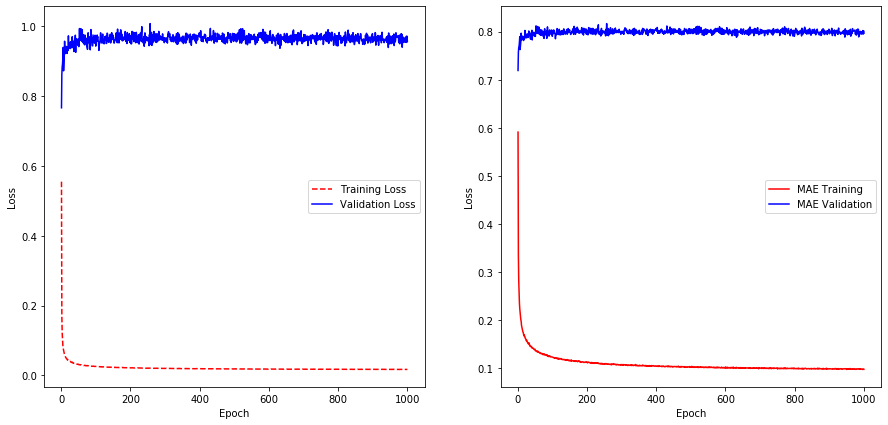

In [31]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']
maes = history.history['mae']
val_maes = history.history['val_mae']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--')
ax1.plot(epoch_count, val_loss, 'b-')
ax1.legend(['Training Loss', 'Validation Loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, maes, 'r-')
ax2.plot(epoch_count, val_maes, 'b-')
ax2.legend(['MAE Training', 'MAE Validation'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [29]:
model_filename = "training/20191215_181258.h5"

In [30]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [31]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [32]:
def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, te_y, "Validation")

--- Train Set ---
predicted: 0.6030199527740479
true:      0.5258485674858093
mse:       0.005955422762781382
mae:       0.07717138528823853


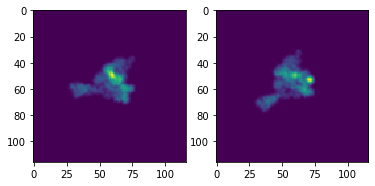

In [33]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.89448881149292
true:      1.5939079523086548
mse:       1.691510558128357
mae:       1.3005808591842651


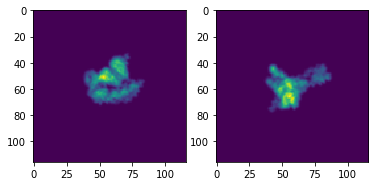

In [34]:
plot_validation_results(0)

---

## dP/dQ plot

### dP/dQ on Training

In [35]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)

In [36]:
# Creating the dataframe for SNS plot
data = {"d_Q" : tr_y.numpy(),
        "d_P" : y_tr_pred.T[0]}
df = pd.DataFrame(data=data)

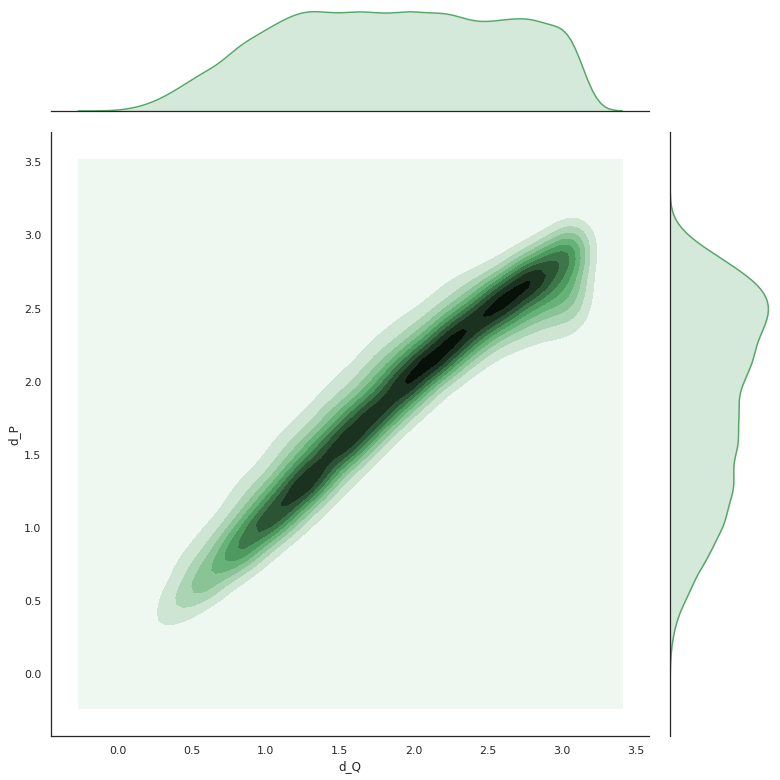

In [37]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

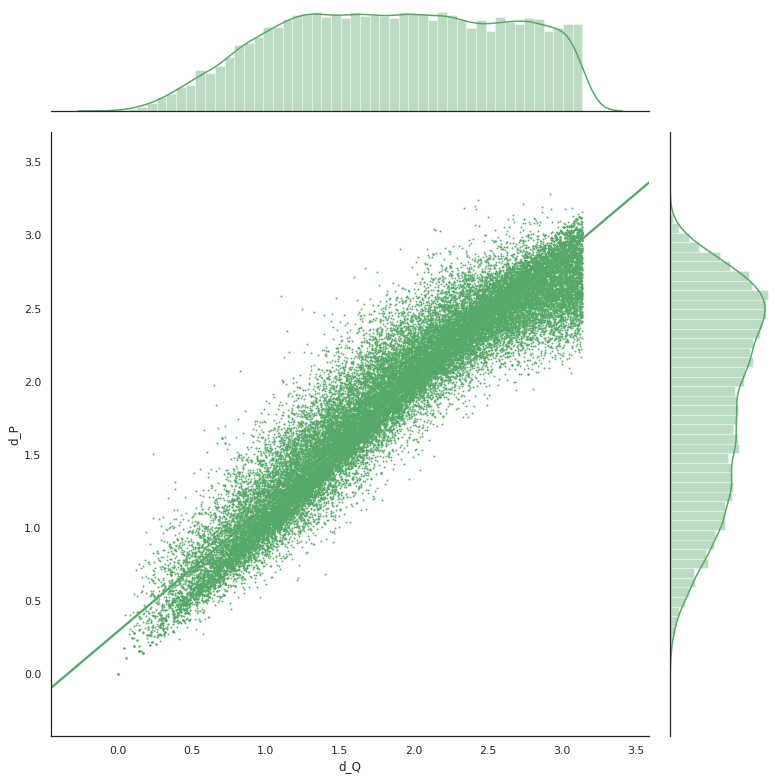

In [38]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

In [39]:
from scipy.stats import linregress

lr = linregress(df.d_Q, df.d_P)
slope, intercept = lr.slope, lr.intercept
print(f"d_P/d_Q = {slope}, intercept = {intercept}")

d_P/d_Q = 0.8539558898298867, intercept = 0.2912453164740496


### dP/dQ on Validation

In [40]:
# Creating the dataframe for SNS plot
data = {"d_Q" : val_y.numpy(),
        "d_P" : y_val_pred.T[0]}
df = pd.DataFrame(data=data)

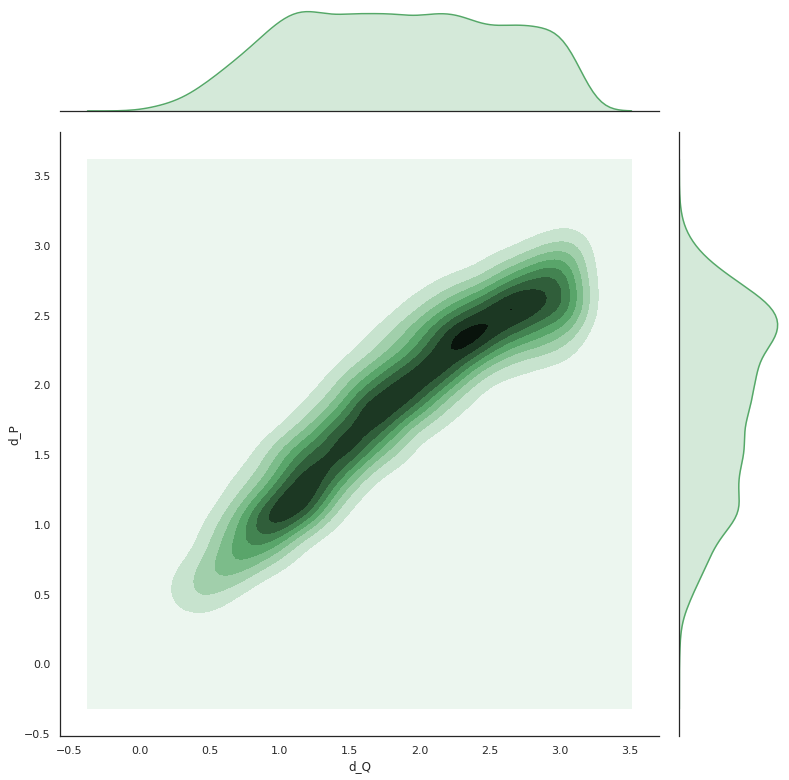

In [41]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

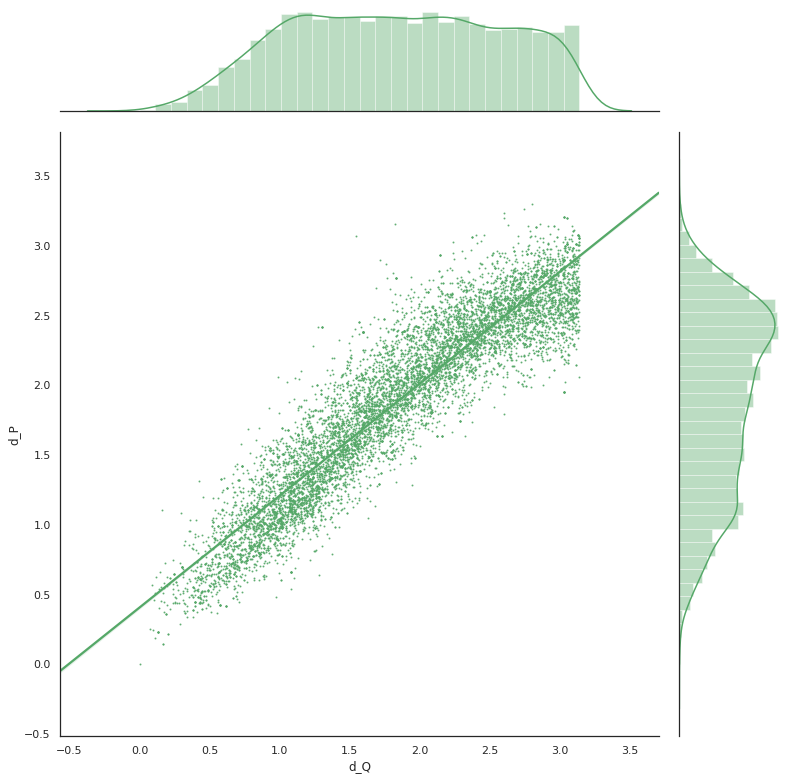

In [42]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

In [43]:
from scipy.stats import linregress

lr = linregress(df.d_Q, df.d_P)
#slope, intercept = lr.slope, lr.intercept
print(f"d_P/d_Q = {lr.slope}, intercept = {lr.intercept}")

d_P/d_Q = 0.8014365971204938, intercept = 0.4052898038106123


---

# 2. Angle Recovery

In [44]:
num_pairs = 10000

###### Predicted Angles (initialization)

In [45]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(NUM_PROJECTIONS, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0001, 6.2813)


(5000,)

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [46]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [47]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

In [48]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=num_pairs, style="knn_and_random", k=k)
        
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [y[i] for i in idx1]
        a2_true = [y[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [49]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

## Optimization loop (projection-true & angles-predict)

##### True Angles

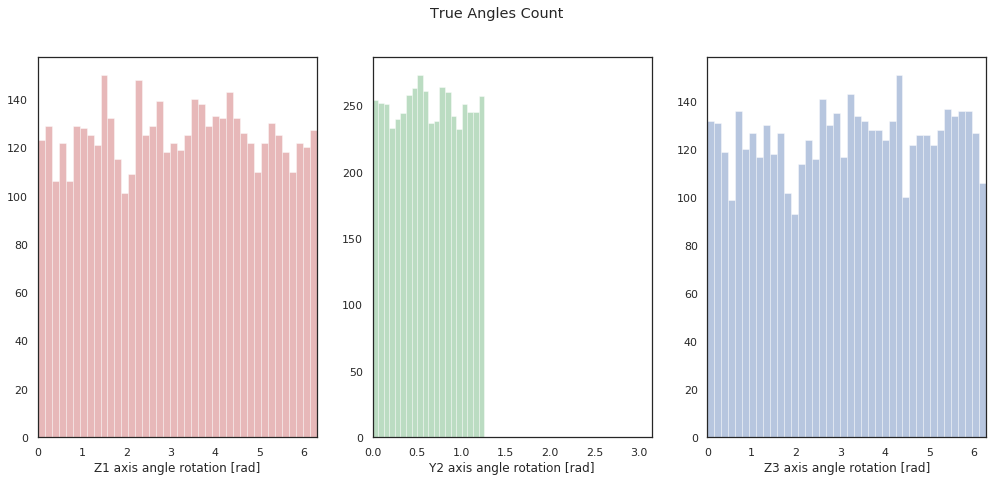

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(y[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(y[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(y[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Predicted Angles [INITIAL]

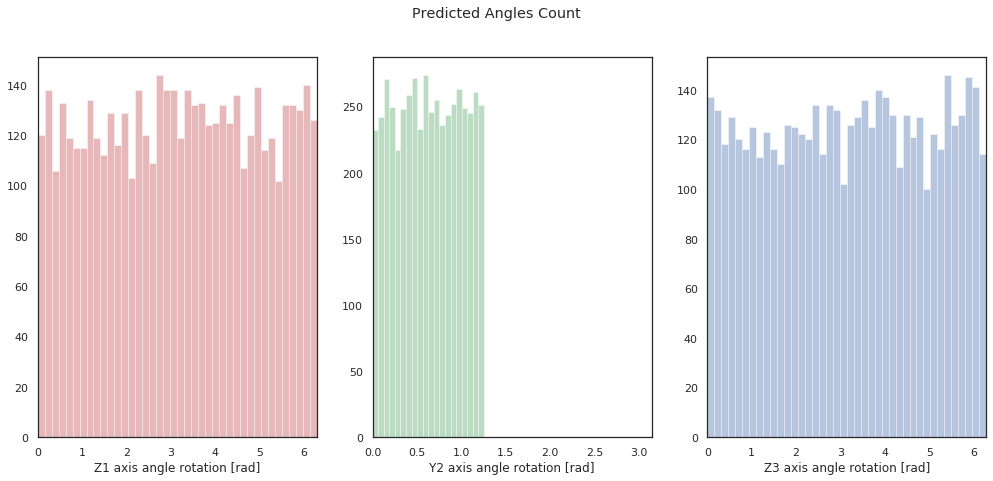

In [51]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [52]:
loss_predicted_vs_true_angle(steps=1000, batch_size=256)

step 100/1000 (243s): loss = 1.08e+00
step 200/1000 (484s): loss = 1.09e+00
step 300/1000 (727s): loss = 1.09e+00
step 400/1000 (969s): loss = 1.12e+00
step 500/1000 (1211s): loss = 1.08e+00
step 600/1000 (1452s): loss = 1.07e+00
step 700/1000 (1696s): loss = 1.11e+00
step 800/1000 (1938s): loss = 1.09e+00
step 900/1000 (2180s): loss = 1.10e+00
step 1000/1000 (2423s): loss = 1.08e+00
Mean loss: 1.0870498448366044


step 300/3000 (4886s): loss = 8.63e-01
step 600/3000 (9718s): loss = 8.35e-01
step 900/3000 (14514s): loss = 8.16e-01
step 1200/3000 (19265s): loss = 8.06e-01
step 1500/3000 (24009s): loss = 7.83e-01
step 1800/3000 (28755s): loss = 7.61e-01
step 2100/3000 (33503s): loss = 7.31e-01
step 2400/3000 (38250s): loss = 6.99e-01
step 2700/3000 (42986s): loss = 7.08e-01
step 3000/3000 (47719s): loss = 7.06e-01


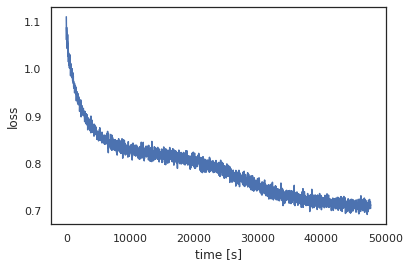

In [53]:
steps=3000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.001)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=num_pairs, style="knn_and_random", k=k)
    
    # Compute distances between projections
    p1 = [X[i] for i in idx1]
    p2 = [X[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dQspace")
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

11:37-1500/5000

In [54]:
loss_predicted_vs_true_angle(steps=1000, batch_size=256)

step 100/1000 (241s): loss = 6.88e-01
step 200/1000 (482s): loss = 6.96e-01
step 300/1000 (723s): loss = 6.90e-01
step 400/1000 (964s): loss = 7.07e-01
step 500/1000 (1211s): loss = 6.93e-01
step 600/1000 (1452s): loss = 6.98e-01
step 700/1000 (1693s): loss = 6.91e-01
step 800/1000 (1934s): loss = 6.84e-01
step 900/1000 (2176s): loss = 7.02e-01
step 1000/1000 (2416s): loss = 7.05e-01
Mean loss: 0.6955007568676355


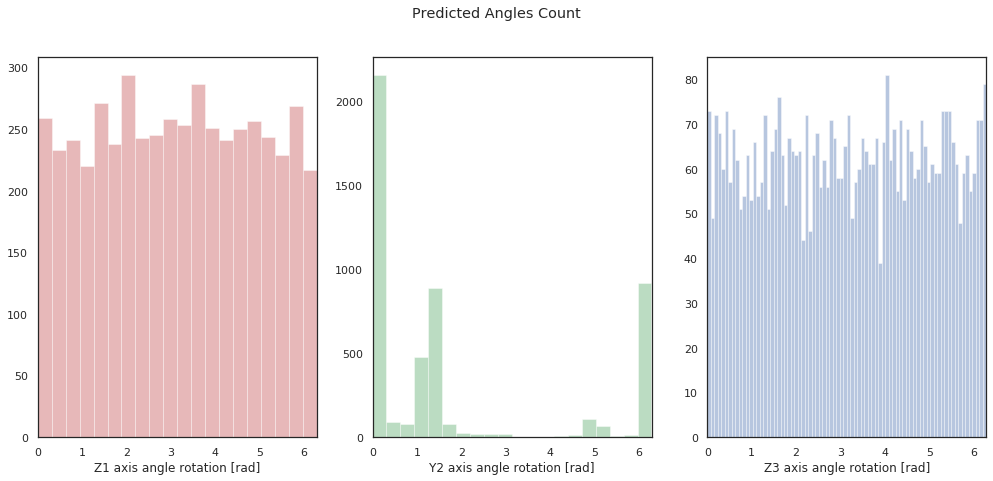

In [55]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [56]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()